In [3]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [4]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.encoders_decoders import decoder_with_fc_only, encoder_with_convs_and_symmetry_new
from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id
from tflearn.layers.conv import avg_pool_1d
from pc_completions.evaluation import basic_comletion_measures

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
n_pc_points = 2048
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))

In [7]:
train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt')
val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt')
test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/test.txt')

# train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/train.txt')
# val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/val.txt')
# test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_medium_size_splits/test.txt')

# train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/train.txt')
# val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/val.txt')
# test_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/wu_small_size_splits/test.txt')

In [8]:
do_training = True
load_pretrained_model = False
load_epoch = None
random_seed = 42
loss = 'chamfer'
bneck_size = 128

In [22]:
splitter = Data_Splitter(top_pclouds_path, data_file_ending='.ply', random_seed=random_seed)

tr_files = splitter.load_splits(train_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(tr_files, n_threads=12, loader=snc_loader, verbose=True)

train_mu = np.mean(pclouds, axis=0)
# train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)
train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids, noise=pclouds-train_mu)


val_files = splitter.load_splits(val_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(val_files, n_threads=12, loader=snc_loader, verbose=True)
# val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids, noise=pclouds-train_mu)

test_files = splitter.load_splits(test_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(test_files, n_threads=12, loader=snc_loader, verbose=True)
# test_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)
test_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids, noise=pclouds-train_mu)

5761 pclouds were loaded. They belong in 1 shape-classes.
338 pclouds were loaded. They belong in 1 shape-classes.
679 pclouds were loaded. They belong in 1 shape-classes.


In [23]:
encoder_args = {'n_filters': [32, 64, 64, 128, 20],
                'filter_sizes': [20, 8, 4, 4, 2],
                'strides': [1, 1, 1, 1, 1],
                'pool': avg_pool_1d,
                'pool_sizes': [4, 2, None, 2, None],
                'symmetry': None,
                'b_norm': True,
                'verbose': True            
                }


decoder_args = {'layer_sizes': [bneck_size, 256, n_pc_points*3], 'b_norm':False, 'verbose': True}

# decoder_args = {'n_filters': [6, 6, 12, 12],
#                 'filter_sizes': [2, 2, 4, 8],
#                 'strides': [1, 1, 1, 1],
#                 'pool': None,
#                 'b_norm': b_norm,
#                 'symmetry': None,
#                 }
# layer = tf.placeholder(tf.[None, n_p, 3])
# layer = deconvolution_op(layer, activation='relu', nb_filter=64, filter_size=2, strides=1)
# avg_pool_1d()
# from tflearn.layers.conv import conv_1d
# from tflearn.layers.normalization import batch_normalization

# deconvolution_op = conv_1d
# non_linearity = tf.nn.relu
# def convolutional_decoder(in_signal):
#     layer = in_signal
#     print layer
#     layer = deconvolution_op(layer, activation='relu', nb_filter=64, filter_size=2, strides=1)
#     avg_pool_1d()
#     layer = batch_normalization(layer)
# #     layer = non_linearity(layer)
# #     print layer
# #     layer = deconvolution_op(layer, nb_filter=64, filter_size=2, strides=1)
# #     layer = non_linearity(layer)
# #     layer = batch_normalization(layer)
#     print layer
#     layer = deconvolution_op(layer, activation='relu', nb_filter=128, filter_size=4, strides=1)
# #     layer = non_linearity(layer)
#     layer = batch_normalization(layer)
#     print layer
#     layer = deconvolution_op(layer, activation='relu', nb_filter=192, filter_size=9, strides=1)    
#     layer = batch_normalization(layer)
#     print layer
#     return layer

In [24]:
experiment_name = 'lex_conv_with_mu_centering'
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/testing_ae_settings', experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/testing_ae_settings/lex_conv_with_mu_centering'

In [25]:
if load_pretrained_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
    if conf.train_dir != train_dir:
        conf.train_dir = train_dir
    conf.save(osp.join(train_dir, 'configuration'))
else:
    conf = Conf(
                n_input = [n_pc_points, 3],
                loss = loss,
                training_epochs = 500,
                batch_size = 50,
                denoising = True,
                learning_rate = 0.0005,
                train_dir = train_dir,             
                loss_display_step = 1,
                saver_step = None,
                z_rotate = False,
                encoder = encoder_with_convs_and_symmetry_new, 
                decoder = decoder_with_fc_only,
                encoder_args = encoder_args,
                decoder_args = decoder_args
               )
    
    conf.experiment_name = experiment_name
    conf.held_out_step = 5
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [26]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)
print ae.trainable_parameters()

Building Encoder
encoder_conv_layer_0 conv params =  1952 bnorm params =  64
Tensor("lex_conv_with_mu_centering_2/AvgPool1D/Squeeze:0", shape=(?, 512, 32), dtype=float32)
output size: 16384 

encoder_conv_layer_1 conv params =  16448 bnorm params =  128
Tensor("lex_conv_with_mu_centering_2/AvgPool1D_1/Squeeze:0", shape=(?, 256, 64), dtype=float32)
output size: 16384 

encoder_conv_layer_2 conv params =  16448 bnorm params =  128
Tensor("lex_conv_with_mu_centering_2/Relu_2:0", shape=(?, 256, 64), dtype=float32)
output size: 16384 

encoder_conv_layer_3 conv params =  32896 bnorm params =  256
Tensor("lex_conv_with_mu_centering_2/AvgPool1D_2/Squeeze:0", shape=(?, 128, 128), dtype=float32)
output size: 16384 

encoder_conv_layer_4 conv params =  5140 bnorm params =  40
Tensor("lex_conv_with_mu_centering_2/Relu_4:0", shape=(?, 128, 20), dtype=float32)
output size: 2560 

Building Decoder
decoder_fc_0 FC params =  327808 Tensor("lex_conv_with_mu_centering_2/Relu_5:0", shape=(?, 128), dtype=

In [28]:
if do_training:
    buf_size = 1 # flush each line
    fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
    train_stats = ae.train(train_data, conf, log_file=fout, held_out_data=val_data)
    fout.close()

('Epoch:', '0002', 'training time (minutes)=', '0.1042', 'loss=', '0.001870679')
('Epoch:', '0003', 'training time (minutes)=', '0.0992', 'loss=', '0.001676596')
('Epoch:', '0004', 'training time (minutes)=', '0.0903', 'loss=', '0.001537758')
('Epoch:', '0005', 'training time (minutes)=', '0.1106', 'loss=', '0.001462427')
('Held Out Data :', 'forward time (minutes)=', '0.0009', 'loss=', '0.001521647')
('Epoch:', '0006', 'training time (minutes)=', '0.1530', 'loss=', '0.001408231')
('Epoch:', '0007', 'training time (minutes)=', '0.1184', 'loss=', '0.001407610')
('Epoch:', '0008', 'training time (minutes)=', '0.1174', 'loss=', '0.001314279')
('Epoch:', '0009', 'training time (minutes)=', '0.1014', 'loss=', '0.001277650')
('Epoch:', '0010', 'training time (minutes)=', '0.1117', 'loss=', '0.001266022')
('Held Out Data :', 'forward time (minutes)=', '0.0007', 'loss=', '0.001295160')
('Epoch:', '0011', 'training time (minutes)=', '0.0997', 'loss=', '0.001231026')
('Epoch:', '0012', 'training

In [40]:
ae.reconstruct??

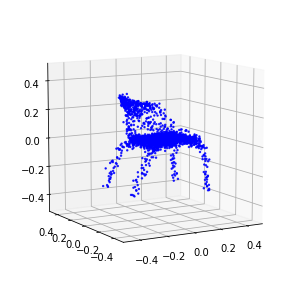

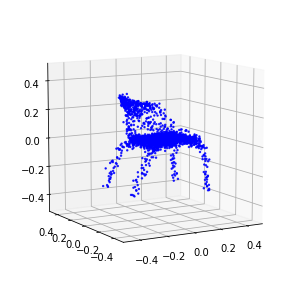

In [49]:
# ae.sess.run()
# Point_Cloud(ae.reconstruct(test_data.noisy_point_clouds[2:3], compute_loss=False)[0][0]).plot()
# train_data.point_clouds[:1][0]

array([[[ 0.03170195,  0.08507123,  0.07321307],
        [-0.00132271,  0.02802314,  0.03024377],
        [-0.01999983, -0.17190281,  0.08891808],
        ..., 
        [ 0.20199203,  0.02214013,  0.15150546],
        [-0.02289614, -0.0073282 ,  0.16007985],
        [-0.13206352,  0.06691333,  0.09004211]]], dtype=float32)

In [1]:
# Point_Cloud(ae.reconstruct(np.expand_dims(train_data.point_clouds[4], 0))[0][0]).plot()

NameError: name 'Point_Cloud' is not defined